#Input data

In [1]:
DATABASE = {
    100:[0.7, -1, 0.1, -1 ],
    200:[0.4, 0.4, 0.5, 0.9],
    300:[-1, 0.6, 0.3, 0.2],
    400:[-1, -1, 0.4, 0.4],
    500:[1, 0.7, -1, -1],
    600:[-1, -1, 0.2, 0.8],
    700:[0.9, 0.9, 0.9, -1]
}
ITEMS = ["A", "B", "C", "D"]
ITEMS_INDEX = {"A": 0, "B": 1, "C": 2, "D": 3}

#Define UPlist and IMCUPList

In [2]:
class UPList:
  def __init__(self, item):
    self.item = {item}
    self.table = {"TID": [], "Prob": []}
    self.expSup = 0
    self.max = 0
  def __eq__(self, other):
    return self.expSup == other.expSup
  def __gt__(self, other):
    return self.expSup > other.expSup
  def __lt__(self, other):
    return self.expSup < other.expSup

class IMCUPList(UPList):
  def __init__(self, U1, U2):
    UPList.__init__(self, "")
    self.item = U1.item.union(U2.item)
    self.index1 = -1
    self.index2 = -1
    self.U1 = U1
    self.U2 = U2
  def genTableIMCUP(self, minSup):
    self.index2 += 1
    for self.index1 in range (self.index1 + 1, len(self.U1.table["TID"])):
      while self.U1.table["TID"][self.index1] > self.U2.table["TID"][self.index2] and self.index2 < len(self.U2.table["TID"]) - 1:
        self.index2 += 1
      if self.U1.table["TID"][self.index1] == self.U2.table["TID"][self.index2]:
        self.table["TID"].append(self.U1.table["TID"][self.index1])
        prob = self.U1.table["Prob"][self.index1] * self.U2.table["Prob"][self.index2]
        self.table["Prob"].append(prob)
        self.expSup += prob
        self.max = max(self.max, prob)
        if minSup - self.expSup > (len(self.U1.table["TID"]) - self.index1 - 1) * self.U1.max:
          return
      if self.index2 == len(self.U2.table["TID"]) - 1:
        self.index1 = len(self.U1.table["TID"]) - 1
        return




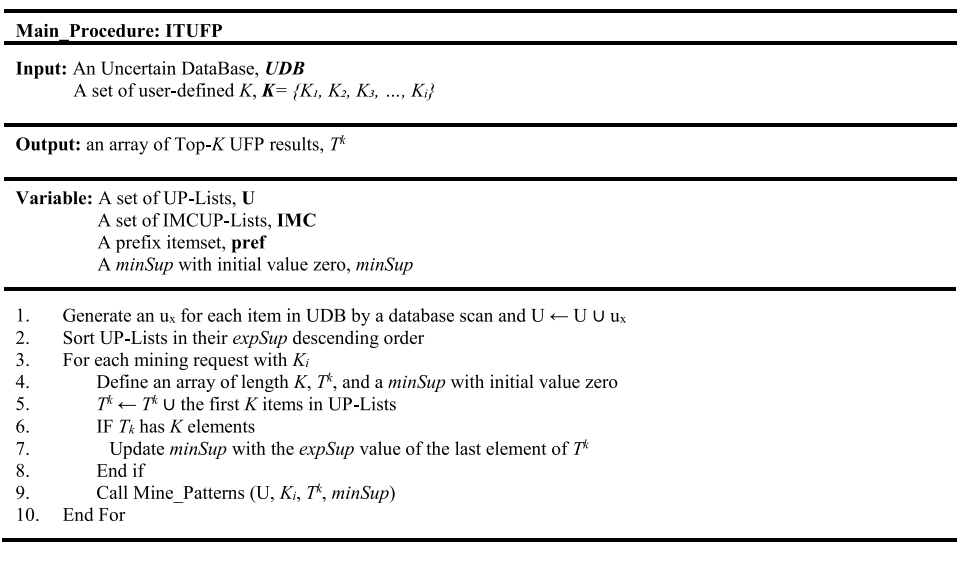

#ITUFP

In [3]:
def ITUFP(UDB, K: list):
  U = []

  IMC =  dict()
  pref =  dict()

  def ITUFP_growth(UIMC,Ki,TK,minSup):
    print(f"*****************************************")
    print(" Mine_patterns")
    for x in range(len(UIMC)):
      print("Considered Ux:", "".join(UIMC[x].item))
      if UIMC[x].expSup > minSup:
        if "".join(UIMC[x].item) not in pref:
          print("".join(UIMC[x].item), "not in pref create IMC and pref for", "".join(UIMC[x].item))
          IMC["".join(UIMC[x].item)] = []
          pref["".join(UIMC[x].item)] = []
        for l in range(x + 1, len(UIMC)):
          if UIMC[l].expSup > minSup:
            print("Considered Ul:", "".join(UIMC[l].item))
            if UIMC[x].expSup * UIMC[l].max > minSup:
              index = -1
              if "".join(UIMC[x].item.union(UIMC[l].item)) in pref["".join(UIMC[x].item)]:
                index = pref["".join(UIMC[x].item)].index("".join(UIMC[x].item.union(UIMC[l].item)))
                if IMC["".join(UIMC[x].item)][index].index1 != len(UIMC[x].table["TID"]) - 1 and IMC["".join(UIMC[x].item)][index].index2 != len(UIMC[l].table["TID"]) - 1:
                  print("Update IMC:",IMC["".join(UIMC[x].item)][index].item)
                  IMC["".join(UIMC[x].item)][index].genTableIMCUP(minSup)
              else:
                C = IMCUPList(UIMC[x], UIMC[l])
                C.genTableIMCUP(minSup)
                IMC["".join(UIMC[x].item)].append(C)
                pref["".join(UIMC[x].item)].append("".join(C.item))
                print("Create IMC:",IMC["".join(UIMC[x].item)][index].item)
              if IMC["".join(UIMC[x].item)][index].expSup > minSup:
                print("IMC:\n",IMC)
                print("pref:\n",pref)
                inserted = False
                for i in range (len(TK["TID"])):
                  if TK["expSup"][i] < IMC["".join(UIMC[x].item)][index].expSup:
                    TK["TID"].insert(i, IMC["".join(UIMC[x].item)][index].item)
                    TK["expSup"].insert(i, IMC["".join(UIMC[x].item)][index].expSup)
                    inserted = True
                    break
                if not inserted:
                  TK["TID"].append(IMC["".join(UIMC[x].item)][index].item)
                  TK["expSup"].append(IMC["".join(UIMC[x].item)][index].expSup)
                if len(TK["TID"]) > Ki:
                  TK["TID"] = TK["TID"][0:Ki]
                  TK["expSup"] = TK["expSup"][0:Ki]
                if len(TK["TID"]) == Ki:
                  minSup = TK["expSup"][-1]
                print("TK:\n",TK)
                print("MinSup:\n",minSup)
        if len(IMC["".join(UIMC[x].item)]) > 1:
          ITUFP_growth(IMC["".join(UIMC[x].item)],Ki,TK,minSup)

  #Create UP-Lists
  for item in (ITEMS):
    U.append(UPList(item))
  for T in (UDB.keys()):
    for item in (ITEMS):
      if UDB[T][ITEMS_INDEX[item]] > 0:
        U[ITEMS_INDEX[item]].expSup += UDB[T][ITEMS_INDEX[item]]
        U[ITEMS_INDEX[item]].max = max(U[ITEMS_INDEX[item]].max, UDB[T][ITEMS_INDEX[item]])
        U[ITEMS_INDEX[item]].table['TID'].append(T)
        U[ITEMS_INDEX[item]].table['Prob'].append(UDB[T][ITEMS_INDEX[item]])
  U.sort(reverse=True)
  TKSet = []
  for Ki in (K):
    print(f"********************{Ki}*********************")
    minSup = 0
    TK = {"TID": [], "expSup": []}
    for i in range (min(Ki,len(U))):
      TK["TID"].append(U[i].item)
      TK["expSup"].append(U[i].expSup)

    #Update minSup if TK has Ki elements
    if len(TK["TID"]) == Ki:
      minSup = TK["expSup"][-1]
    print("TK:\n",TK)
    print("MinSup:\n",minSup)
    ITUFP_growth(U,Ki,TK,minSup)
    TKSet.append(TK)
  return TKSet

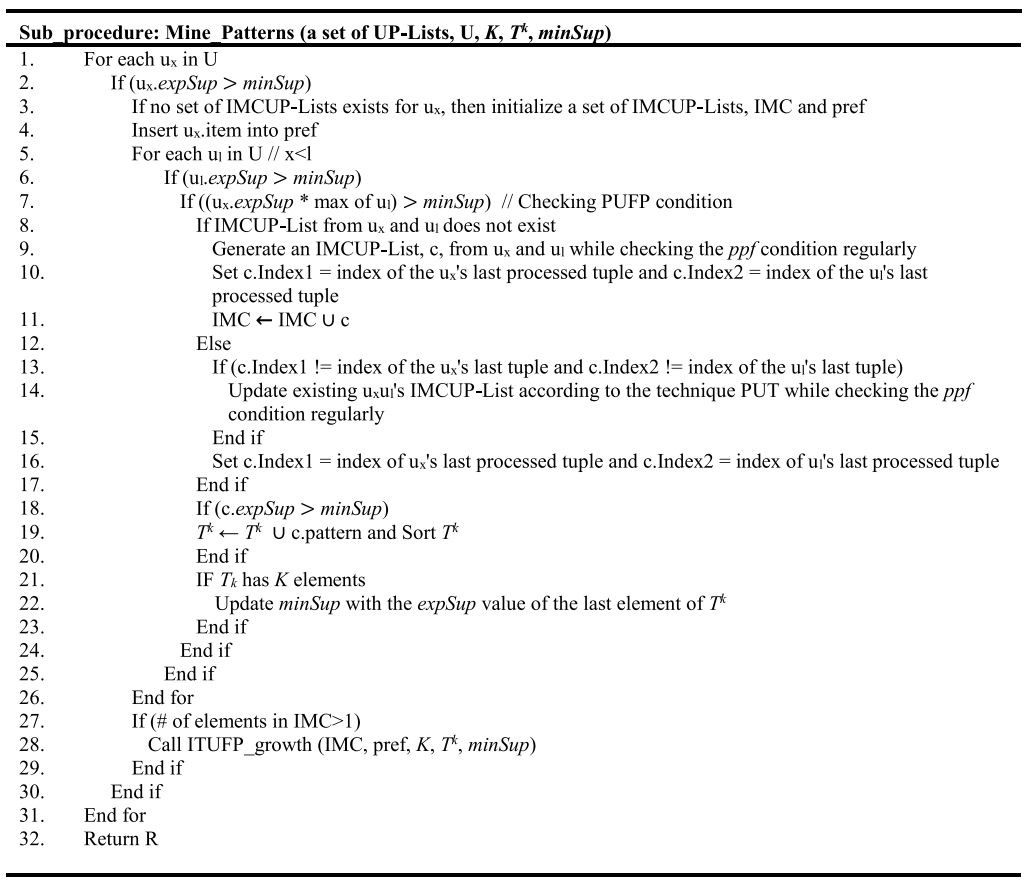

In [4]:
TK = ITUFP(DATABASE, [8,10])
TK



********************8*********************
TK:
 {'TID': [{'A'}, {'B'}, {'C'}, {'D'}], 'expSup': [3.0, 2.6, 2.4, 2.3]}
MinSup:
 0
*****************************************
 Mine_patterns
Considered Ux: A
A not in pref create IMC and pref for A
Considered Ul: B
Create IMC: {'A', 'B'}
IMC:
 {'A': [<__main__.IMCUPList object at 0x7126d1b18260>]}
pref:
 {'A': ['AB']}
TK:
 {'TID': [{'A'}, {'B'}, {'C'}, {'D'}, {'A', 'B'}], 'expSup': [3.0, 2.6, 2.4, 2.3, 1.67]}
MinSup:
 0
Considered Ul: C
Create IMC: {'C', 'A'}
IMC:
 {'A': [<__main__.IMCUPList object at 0x7126d1b18260>, <__main__.IMCUPList object at 0x7126d1b18350>]}
pref:
 {'A': ['AB', 'CA']}
TK:
 {'TID': [{'A'}, {'B'}, {'C'}, {'D'}, {'A', 'B'}, {'C', 'A'}], 'expSup': [3.0, 2.6, 2.4, 2.3, 1.67, 1.08]}
MinSup:
 0
Considered Ul: D
Create IMC: {'D', 'A'}
IMC:
 {'A': [<__main__.IMCUPList object at 0x7126d1b18260>, <__main__.IMCUPList object at 0x7126d1b18350>, <__main__.IMCUPList object at 0x7126d1b183b0>]}
pref:
 {'A': ['AB', 'CA', 'DA']}
TK:
 {

[{'TID': [{'A'},
   {'B'},
   {'C'},
   {'D'},
   {'A', 'B'},
   {'B', 'C'},
   {'A', 'C'},
   {'C', 'D'}],
  'expSup': [3.0, 2.6, 2.4, 2.3, 1.67, 1.19, 1.08, 0.8300000000000001]},
 {'TID': [{'A'},
   {'B'},
   {'C'},
   {'D'},
   {'A', 'B'},
   {'B', 'C'},
   {'A', 'C'},
   {'C', 'D'},
   {'B', 'D'},
   {'A', 'D'}],
  'expSup': [3.0,
   2.6,
   2.4,
   2.3,
   1.67,
   1.19,
   1.08,
   0.8300000000000001,
   0.48000000000000004,
   0.36000000000000004]}]